# MCMC samples from the true posterior for the SIR model

Problem: Given an observed data set, generate MCMC samples from the posterior distribution.

Reason: This is needed in order to define a performance metric.

In [8]:
import numpy as np
import emcee
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import LSTM
from scipy.stats import norm
from scipy.integrate import solve_ivp, dblquad
import random

from bayesflow.networks import InvertibleNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.diagnostics import *
#from bayesflow.error_metrics import *
from bayesflow.models import GenerativeModel

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------
    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) 
    """    
    # Prior range for log-rate parameters: 
    b_samples = np.random.normal(-1.0, 0.25, size=(batch_size, 1))
    c_samples = np.random.normal(-1.5, 0.25, size=(batch_size, 1))
    p_samples = np.c_[b_samples, c_samples]
    return p_samples.astype(np.float32)

# ODE model for SIR dynamics
def sir_dynamics(t, x, theta):
    theta = 10**theta
    return np.array([
            -theta[0]*x[0]*x[1]/N, 
            theta[0]*x[0]*x[1]/N - theta[1]*x[1],
            theta[1]*x[1]
            ])

N = 1000   # population size
x0 = np.array([999, 1, 0])   # initial state       
sigma = 0.05   # noise standard deviation
t_end = 180
n_obs = 21
time_points = np.linspace(0, t_end, n_obs)
missing_max = 15

def batch_simulator_augment01(prior_samples, n_obs):  
    """
    Simulate multiple SIR model data sets with missing values and binary indicator augmentation
    """    
    n_sim = prior_samples.shape[0]   # batch size    
    sim_data = np.ones((n_sim, n_obs, 4), dtype=np.float32)   # 1 batch consisting of n_sim data sets, each with n_obs observations
    n_missing = np.array([11]) #np.random.randint(0, missing_max+1, size=n_sim) 
    
    for m in range(n_sim):
        rhs = lambda t,x: sir_dynamics(t, x, prior_samples[m])
        sol = solve_ivp(rhs, t_span=(0, t_end), y0=x0, t_eval=time_points, atol=1e-9, rtol=1e-6)
        sim_data[m, :, 0:3] = sol.y.T/N + np.random.normal(0, sigma, size=(n_obs, 3))     # observable: y = x + N(0,sigma²)
        
        # artificially induce missing data
        missing_indices = random.sample(range(n_obs), n_missing[m])
        sim_data[m][missing_indices] = np.array([-0.1, -0.1, -0.1, 0.0])
        
    return sim_data   

We build an amortized parameter estimation network.

In [11]:
bf_meta = {
    'n_coupling_layers': 5,
    's_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': 2
}

## Computational faithfulness

In [5]:
n_params = 1
true_params = np.array([[-0.8, -1.4]]) 
x_augment01 = batch_simulator_augment01(true_params, n_obs).astype(np.float32)

In [12]:
%%time
# "True" means via MCMC sampling
mcmc_means = np.empty((n_params, 2))

for i in range(n_params):
    present_timepoints = time_points[x_augment01[i,:,3]==1]
    present_data = x_augment01[i, x_augment01[i,:,3]==1, 0:3]
    
    def log_prior(x,y):   
        # Evaluates log-prior probability p(theta) according to b ~ N(-1, 0.25), c ~ N(-1.5, 0.25)
        return norm.logpdf(x,-1.0,0.25) + norm.logpdf(y,-1.5,0.25)

    def log_likelihood(b,c):   
        # Calculates log-likelihood p(x_{1:N} | theta) by ignoring the missing data
        rhs = lambda t,x: sir_dynamics(t, x, np.array([b,c]))
        sol = solve_ivp(rhs, t_span = (0,t_end), t_eval = present_timepoints, y0 = x0, atol = 1e-9, rtol = 1e-6)
        residual = (present_data - sol.y.T/N)/sigma
        nllh = np.sum(np.log(2*np.pi*sigma**2)+residual**2)/2
        return - nllh

    def log_posterior(x,y):   
        # Evaluates the unnormalized log-posterior probability p(theta | x_{1:N}) according to Bayes' formula
        return log_likelihood(x,y) + log_prior(x,y)

    def log_posterior_v(x: np.ndarray):
        """Log-posterior with a single vector-valued argument."""
        x, y = x
        return log_posterior(x, y)

    def sample(n_sample=10000, n_walker=10):
        """Perform sampling using emcee."""
        n_dim = 2
        p0 = np.random.randn(n_walker, n_dim)
        sampler = emcee.EnsembleSampler(n_walker, n_dim, log_posterior_v)
        sampler.run_mcmc(p0, n_sample)    
        samples = sampler.get_chain(flat=True)
        return samples

    # Sample
    samples = sample(n_sample=1000)
    
    # Posterior mean
    mcmc_means[i] = np.array([np.mean(samples[:, 0]), np.mean(samples[:, 1])])   

Wall time: 2h 31min 29s


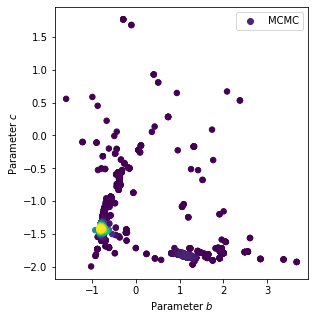

In [13]:
# Plot MCMC against BayesFlow samples
mean_sample = np.mean(samples, axis=0)
cov_sample = np.cov(samples.transpose())
mean_x = mean_sample[0]
mean_y = mean_sample[1]
std_x = np.sqrt(cov_sample[0, 0])
std_y = np.sqrt(cov_sample[1, 1])

fig = plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
a = samples[:, 0]
b = samples[:, 1]
ab = np.vstack([a, b])
z = stats.gaussian_kde(ab)(ab)
ida = z.argsort()  # Sort the points by density, so that the densest points are plotted last
a, b, z = a[ida], b[ida], z[ida]
approximate_posterior = plt.scatter(a, b, c=z, s=30)
h2, _ = approximate_posterior.legend_elements()
plt.legend([h2[0]], ['MCMC'])
plt.xlabel('Parameter $b$')
plt.ylabel('Parameter $c$')
plt.show()

In [52]:
summary_net = LSTM(8)
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)
trainer = ParameterEstimationTrainer(network=amortizer, checkpoint_path='./CR3_augment01_5ACB_[64,64,64]_LSTM(8)_ckpts', skip_checks=True)

# BayesFlow samples from the learned posterior
param_samples_augment01 = amortizer.sample(x_augment01, n_samples=1000)
bayesflow_means = param_samples_augment01.mean(axis=1)

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./CR3_augment01_5ACB_[64,64,64]_LSTM(8)_ckpts\ckpt-300


In [53]:
params = np.c_[mcmc_means, bayesflow_means, true_params]
print(params)

[[-0.72455449 -0.75294824 -0.72911263 -0.75935644 -0.7206437  -0.76974463]
 [-1.08632731 -0.57762746 -1.09444797 -0.58394599 -1.14080679 -0.70397258]
 [-0.7532695  -0.74654883 -0.75063866 -0.75139052 -0.93124372 -0.58484286]]


In [49]:
n_params = 500
true_params = np.load("true_params.npy")
x_augment01 = np.load("x_augment01.npy")
mcmc_means = np.load("mcmc_means.npy")

In [21]:
# Augment by 0/1
summary_net = LSTM(8)
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)
trainer = ParameterEstimationTrainer(network=amortizer, checkpoint_path='./CR3_augment01_5ACB_[64,64,64]_LSTM(8)_ckpts', skip_checks=True)

# BayesFlow samples from the learned posterior
param_samples_augment01 = amortizer.sample(x_augment01, n_samples=1000)
v_augment01 = bootstrap_metrics(np.swapaxes(param_samples_augment01, 0, 1), mcmc_means)
a1 = display_metrics(v_augment01)

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./CR3_augment01_5ACB_[64,64,64]_LSTM(8)_ckpts\ckpt-300
NRMSE(k_1): 0.171 ± 0.009
NRMSE(k_2): 0.133 ± 0.015
R²(k_1): 0.067 ± 0.097
R²(k_2): 0.179 ± 0.112


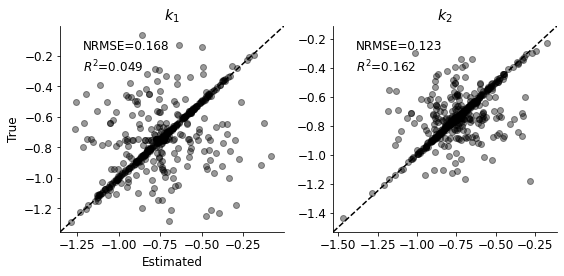

In [22]:
bayesflow_means = param_samples_augment01.mean(axis=1)
f = true_vs_estimated(mcmc_means, bayesflow_means, ['$k_1$', '$k_2$'])

In [23]:
params = np.c_[mcmc_means, bayesflow_means, true_params]
print(params)

[[-0.99583063 -0.69799158 -0.72394121 -0.77604431 -0.7206437  -0.76974463]
 [-0.61780436 -0.72040262 -1.03486073 -0.58747971 -1.14080679 -0.70397258]
 [-1.03251702 -0.58518638 -0.98671252 -0.68601406 -0.93124372 -0.58484286]
 ...
 [-0.58347735 -0.915851   -0.64840347 -0.61463457 -0.6223278  -0.58018827]
 [-0.64524623 -0.61317297 -0.58651286 -0.91783804 -0.67904675 -1.07686889]
 [-0.60292362 -1.16775269 -0.60704964 -1.17625749 -0.61173737 -1.16541636]]


In [14]:
# Insert -1
summary_net = LSTM(8)
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)
trainer = ParameterEstimationTrainer(network=amortizer, checkpoint_path='./CR3_insert-1_5ACB_[64,64,64]_LSTM(8)_ckpts', skip_checks=True)

# BayesFlow samples from the learned posterior
x_insert = np.ones((n_params, n_obs, 1), dtype=np.float32)
for m in range(n_params):
    x_insert[m, :, 0] = x_augment01[m, :, 0]
param_samples_insert = amortizer.sample(x_insert, n_samples=1000)
v_insert = bootstrap_metrics(np.swapaxes(param_samples_insert, 0, 1), mcmc_means)
a2 = display_metrics(v_insert)

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./CR3_insert-1_5ACB_[64,64,64]_LSTM(8)_ckpts\ckpt-300


NRMSE(k_1): 0.173 ± 0.010
NRMSE(k_2): 0.133 ± 0.014
R²(k_1): 0.050 ± 0.101
R²(k_2): 0.177 ± 0.099


In [ ]:
# Time labels
summary_net = LSTM(8)
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)
trainer = ParameterEstimationTrainer(network=amortizer, checkpoint_path='./CR3_timepoints_5ACB_[64,64,64]_LSTM(8)_ckpts', skip_checks=True)
# BayesFlow samples from the learned posterior
param_samples_timepoints = np.empty((n_params, 1000, 2), dtype=np.float32)
for m in range(n_params):
    x = x_augment01[m, :, 1]
    present_indices = np.where(x == 1.)[0]
    x_timepoints = np.empty((1, len(present_indices), 2), dtype=np.float32)
    x_timepoints[0, :, 0] = x_augment01[m, present_indices, 0]
    x_timepoints[0, :, 1] = time_points[present_indices]
    param_samples_timepoints[m] = amortizer.sample(x_timepoints, n_samples=1000)
v_timepoints = bootstrap_metrics(np.swapaxes(param_samples_timepoints, 0, 1), mcmc_means)
a3 = display_metrics(v_timepoints)

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./CR3_timepoints_5ACB_[64,64,64]_LSTM(8)_ckpts\ckpt-300
